In [161]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import multiprocessing as mp

from sklearn.model_selection import train_test_split
from scipy.stats import ttest_rel
from itertools import chain, combinations

# styling:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['ggplot'])
sns.set_palette("deep")

In [162]:
perturbation_factor = 3.0
def choose_2_3(iterable):
    "powerset([1,2,3]) -->  (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(2,4))

In [163]:
exp_name_df = pd.read_csv('./data/bsubtilis/exp_names.tsv', index_col=0, sep='\t', names=['name'])
network_df = pd.read_csv('./data/bsubtilis/gold_standard.tsv', sep='\t', index_col=0)
multi_tf_network_df = network_df.loc[(network_df.sum(axis=1).sort_values(ascending=False) > 4)]
multi_tf_targets = multi_tf_network_df.index
tf_names = multi_tf_network_df.columns.values

In [164]:
exp_genes_set = set(multi_tf_targets).union(set(tf_names))
common_tf_gene = set(multi_tf_targets).intersection(set(tf_names))
for subdir, dirs, files in os.walk('./data/bsubtilis/seq_data/'):
    for file in files:
        df = pd.read_csv(os.path.join(subdir, file), index_col=0, sep='\t', names=['exp'])
        exp_genes_set = exp_genes_set.intersection(set(df.index))

In [165]:
exp_df = pd.DataFrame(index=exp_genes_set)

In [166]:
for subdir, dirs, files in os.walk('./data/bsubtilis/seq_data/'):
    for code_name, exp_name in zip(exp_name_df.index, exp_name_df['name'].values):
        df = pd.read_csv(os.path.join(subdir, code_name+'-tbl-1.txt'), index_col=0, sep='\t', names=['exp'])
        exp_df[exp_name] = df.loc[list(exp_genes_set)]['exp'].values

<ipython-input-166-b12faf3182f3>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  exp_df[exp_name] = df.loc[list(exp_genes_set)]['exp'].values
<ipython-input-166-b12faf3182f3>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  exp_df[exp_name] = df.loc[list(exp_genes_set)]['exp'].values
<ipython-input-166-b12faf3182f3>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) inst

In [167]:
exp_df = exp_df.T

In [168]:
exp_df.to_csv('./data/bsubtilis/expression.csv')

In [169]:
target_set = set(multi_tf_targets).difference(set(tf_names))
tf_names = np.array(list(set(tf_names).intersection(exp_genes_set)))

In [170]:
from xgboost import XGBRFRegressor

In [ ]:
target_set = (set(multi_tf_targets).difference(set(tf_names)))
score_diff_list = []
pval_list = []
regr_score_list = []
regr_score_std_list = []
regr_network_score_list = []
regr_network_score_std_list = []
for target in tqdm(target_set):
    network = network_df.loc[target]
    network_tf = network[network>0].index
    y = exp_df[target]
    X = exp_df[tf_names]
    regr_score = np.empty(0)
    regr_network_score = np.empty(0)
    regr_error_all = np.empty(0)
    regr_network_error_all = np.empty(0)
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i)
        X_train_network = X_train[network_tf]
        X_test_network = X_test[network_tf]
        regr = XGBRFRegressor()
        regr_network = XGBRFRegressor()
        regr.fit(X_train, y_train)
        regr_network.fit(X_train_network, y_train)
        # regr_score_list.append(regr.score(X_test, y_test))
        # regr_network_score_list.append(regr_network.score(X_test_network, y_test))
        # score_diff_list.append(regr.score(X_test, y_test) - regr_network.score(X_test_network, y_test))
        regr_error = np.square(regr.predict(X_test)-y_test).values
        regr_network_error = np.square(regr_network.predict(X_test_network)-y_test).values
        regr_error_all = np.concatenate([regr_error_all, regr_error])
        regr_network_error_all = np.concatenate([regr_network_error_all, regr_network_error])
    regr_score_list.append(np.sqrt(np.mean(regr_error_all)))
    regr_network_score_list.append(np.sqrt(np.mean(regr_network_error_all)))
    regr_score_std_list.append(np.sqrt(np.std(regr_error_all)))
    regr_network_score_std_list.append(np.sqrt(np.std(regr_network_error_all)))
    score_diff_list.append(np.sqrt(np.mean(regr_network_error_all)) - np.sqrt(np.mean(regr_error_all)))
    t_stats, pval = ttest_rel(regr_error_all, regr_network_error_all)
    pval_list.append(pval)
    

In [ ]:
model_comp_df = pd.DataFrame(index=list(target_set))
model_comp_df['network_model_score'] = regr_network_score_list
model_comp_df['all_model_score'] = regr_score_list
model_comp_df['score_diff'] = score_diff_list
model_comp_df['score_diff_pval'] = pval_list

In [ ]:
model_comp_df = model_comp_df.sort_values(by=['network_model_score'], ascending=[True])
model_comp_df.to_csv('./output/bsubtilis/model_compare.csv')

In [12]:
model_comp_df = pd.read_csv('./output/bsubtilis/model_compare.csv', index_col=0)
model_comp_df = model_comp_df.sort_values(by=['network_model_score'], ascending=[True])

In [ ]:
for target in target_set:
    y = exp_df[target]
    X = exp_df[tf_names]
    y_std = y.std()
    input_mean = X.mean()
    input_std = X.std()
    network = network_df.loc[target]
    network_tf = network[network>0].index.values
    X_network = X[network_tf]
    input_mean_network = X_network.mean()
    input_std_network = X_network.std()


    perturbation_list = list(choose_2_3(network_tf))
    perturbation_list_names = ['; '.join(perturbation_genes) for perturbation_genes in perturbation_list]
    perturbation_measure_df = pd.DataFrame(index=perturbation_list_names)
    perturbation_additive_measure_df = pd.DataFrame(index=perturbation_list_names)

    for i in tqdm(range(1000)):

        # regr = XGBRFRegressor()
        regr_network = XGBRFRegressor(random_state=i)
        # regr.fit(X, y)
        regr_network.fit(X_network, y)

        base_prediction = regr_network.predict(np.array(input_mean_network).reshape(1,-1))[0]

        single_effect_dict = dict()
        for tf in network_tf:
            perturbation_input = input_mean_network.copy()
            perturbation_input[tf] += input_std[tf] * perturbation_factor
            perturbation_prediction = regr_network.predict(np.array(perturbation_input).reshape(1,-1))[0]
            perturbation_measure = (perturbation_prediction - base_prediction)/y_std
            single_effect_dict[tf] = perturbation_measure

        perturbation_result_list = []
        perturbation_additive_result_list = []

        for perturbation_genes in perturbation_list:
            perturbation_input = input_mean_network.copy()
            additive_effects = 0
            for gene in perturbation_genes:
                perturbation_input[gene] += input_std[gene] * perturbation_factor
                additive_effects += np.abs(single_effect_dict[gene])
            perturbation_prediction = regr_network.predict(np.array(perturbation_input).reshape(1,-1))[0]
            perturbation_measure = (perturbation_prediction - base_prediction)/y_std
            perturbation_result_list.append(perturbation_measure)
            perturbation_additive_result_list.append(additive_effects)
        perturbation_measure_df[i] = perturbation_result_list
        perturbation_measure_df = perturbation_measure_df.copy()
        perturbation_additive_measure_df[i] = perturbation_additive_result_list
        perturbation_additive_measure_df = perturbation_additive_measure_df.copy()
    measure_diff_df = pd.DataFrame(index=perturbation_list_names)
    pval_list = []
    measure_diff_list = []
    measure_relative_diff_list = []
    for i in perturbation_measure_df.index:
        perturbation_measure = perturbation_measure_df.loc[i].abs()
        perturbation_additive_measure = perturbation_additive_measure_df.loc[i].abs()
        mean_measure_diff = perturbation_measure.mean() - perturbation_additive_measure.mean()
        mean_measure_relative_diff = mean_measure_diff / perturbation_additive_measure.mean()
        t_stats, pval = ttest_rel(perturbation_measure, perturbation_additive_measure)
        measure_diff_list.append(mean_measure_diff)
        measure_relative_diff_list.append(mean_measure_relative_diff)
        pval_list.append(pval)
    measure_diff_df['mean_measure_diff'] = measure_diff_list
    measure_diff_df['measure_relative_diff_list'] = measure_relative_diff_list
    measure_diff_df['pval'] = pval_list
    measure_diff_df.sort_values(by='measure_relative_diff_list', ascending=False).to_csv('./output/bsubtilis/'+target+'_tf_synergy_measure_abs.csv')



<ipython-input-122-6fc572afbd9e>:21: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(sm, pad=0.01)


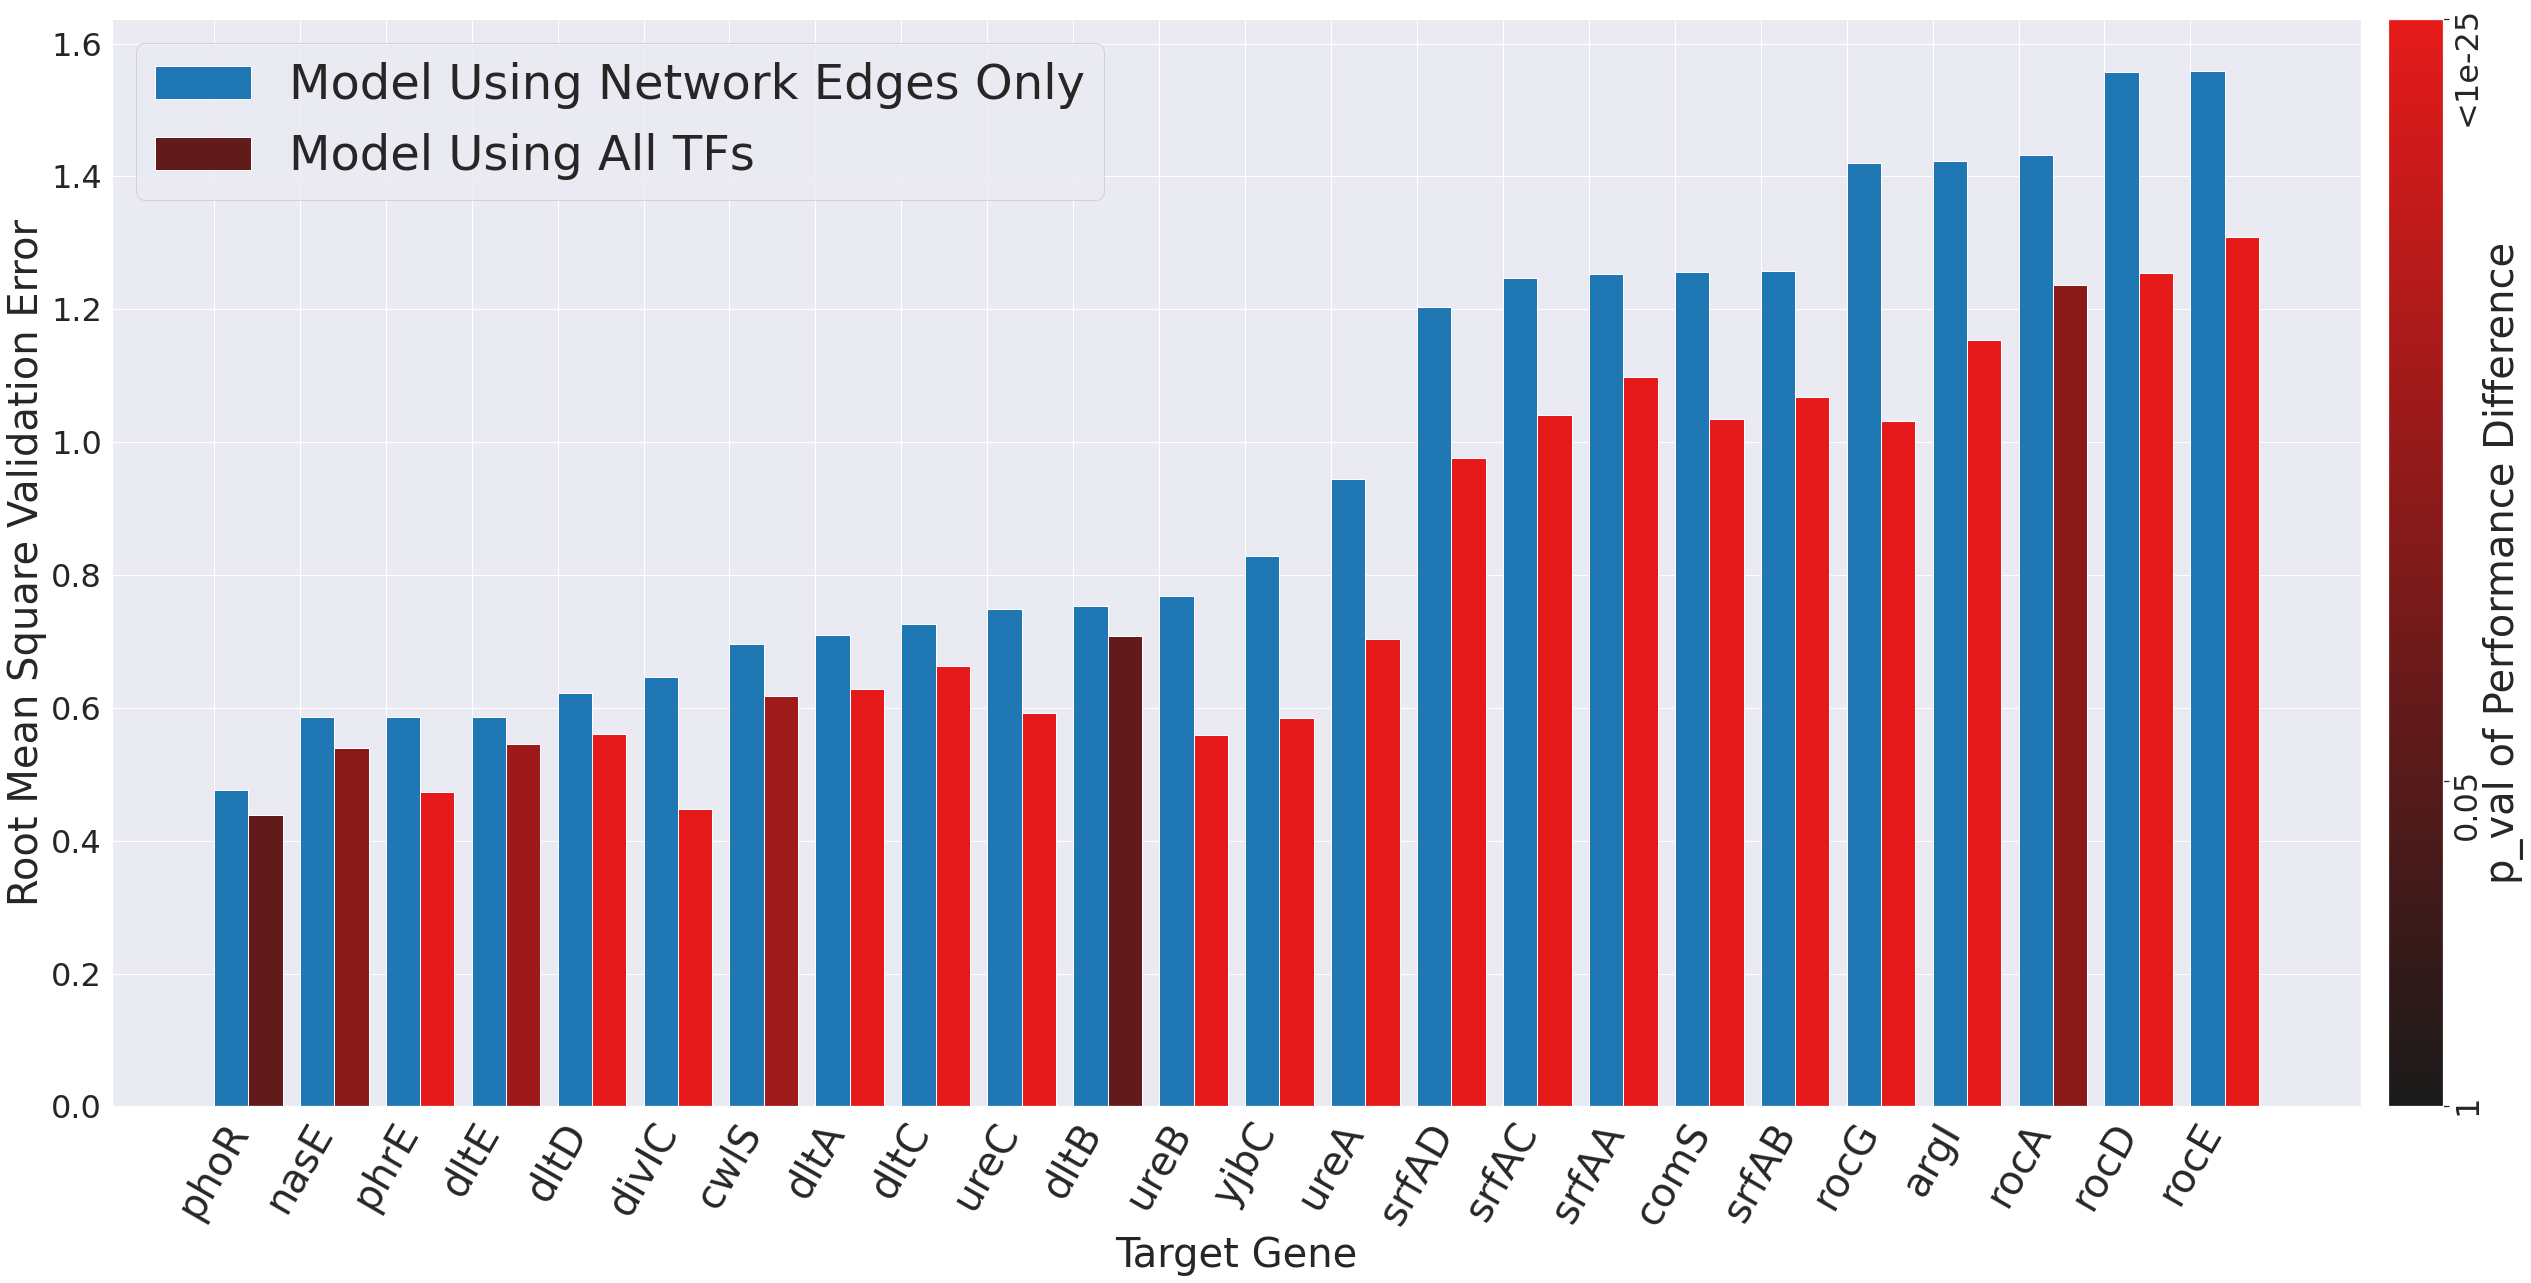

In [122]:
import matplotlib.colors
from matplotlib.cm import ScalarMappable

norm=plt.Normalize(0, 10)
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [(0.1, 0.1, 0.1), (0.9, 0.1, 0.1)])
# my_cmap = plt.cm.get_cmap('GnBu')
sm = ScalarMappable(cmap=my_cmap, norm=norm)
sm.set_array([])
colors = my_cmap([np.abs(np.log(pval))/10 for pval in model_comp_df['score_diff_pval']])


fig, ax = plt.subplots()
fig.set_size_inches(48,20)


bar_width = 0.4
ax.bar(range(len(model_comp_df)), model_comp_df['network_model_score'], bar_width, align='edge', color='tab:blue',  label='Model Using Network Edges Only')
plt.bar(np.array(range(len(model_comp_df)))+bar_width, model_comp_df['all_model_score'], bar_width, align='edge', 
       color=colors, label='Model Using All TFs')

cbar = plt.colorbar(sm, pad=0.01)
cbar.set_label('p_val of Performance Difference', rotation=90, labelpad=0, fontsize=40)
cbar.ax.tick_params(rotation=90, labelsize=32)
cbar.set_ticks([0,-np.log(0.05),10])
cbar.set_ticklabels([1,0.05,'<1e-25'])

plt.xticks(range(len(model_comp_df)), labels=subtilis_gene_meta_df.loc[model_comp_df.index.values].Locus, rotation=60, fontsize=40)
plt.yticks(fontsize=32)


plt.legend(fontsize=48)
plt.ylabel('Root Mean Square Validation Error', fontsize=40)
plt.xlabel('Target Gene', fontsize=40)


plt.show()

In [15]:
from os import listdir
from os.path import isfile, join
files = []

for i in os.listdir('./output/bsubtilis/'):
    if os.path.isfile(os.path.join('./output/bsubtilis/',i)) and '_abs' in i:
        files.append(os.path.join('./output/bsubtilis/',i))

In [16]:
subtilis_gene_meta_df = pd.read_csv('./data/bsubtilis/gene_list.csv', index_col=0)
def replace_name(name_list):
    for k in subtilis_gene_meta_df.index:
        tag_name = subtilis_gene_meta_df.loc[k]['Locus tag']
        if (tag_name in name_list):
            name_list = name_list.replace(tag_name, subtilis_gene_meta_df.loc[k]['Locus'])
    return name_list

In [19]:
for measure_file in tqdm(files):
    df = pd.read_csv(measure_file, index_col=0)
    df['gene_names'] = [replace_name(tag_name) for tag_name in df.index]
    df.to_csv(measure_file)

100%|██████████| 24/24 [02:12<00:00,  5.50s/it]


In [26]:
subtilis_gene_meta_df.loc[subtilis_gene_meta_df['Locus tag'] == 'BSU00620']['Locus'].iloc[0]


'divIC'

In [45]:
subtilis_synergy_df = pd.DataFrame(index=range(20))
subtilis_synergy_name_df = pd.DataFrame(index=range(20))

In [47]:
for measure_file in files:
    target_tag = measure_file.split('_')[0].split('/')[-1]
    target_name = subtilis_gene_meta_df.loc[subtilis_gene_meta_df['Locus tag'] == target_tag]['Locus'].iloc[0]
    df = pd.read_csv(measure_file, index_col=0)
    subtilis_synergy_df[target_name] = df['measure_relative_diff_list'].head(20).values
    subtilis_synergy_name_df[target_name] = df['gene_names'].head(20).values

In [79]:
subtilis_synergy_df = subtilis_synergy_df.reindex(sorted(subtilis_synergy_df.columns), axis=1)
subtilis_synergy_name_df = subtilis_synergy_name_df.reindex(sorted(subtilis_synergy_name_df.columns), axis=1)


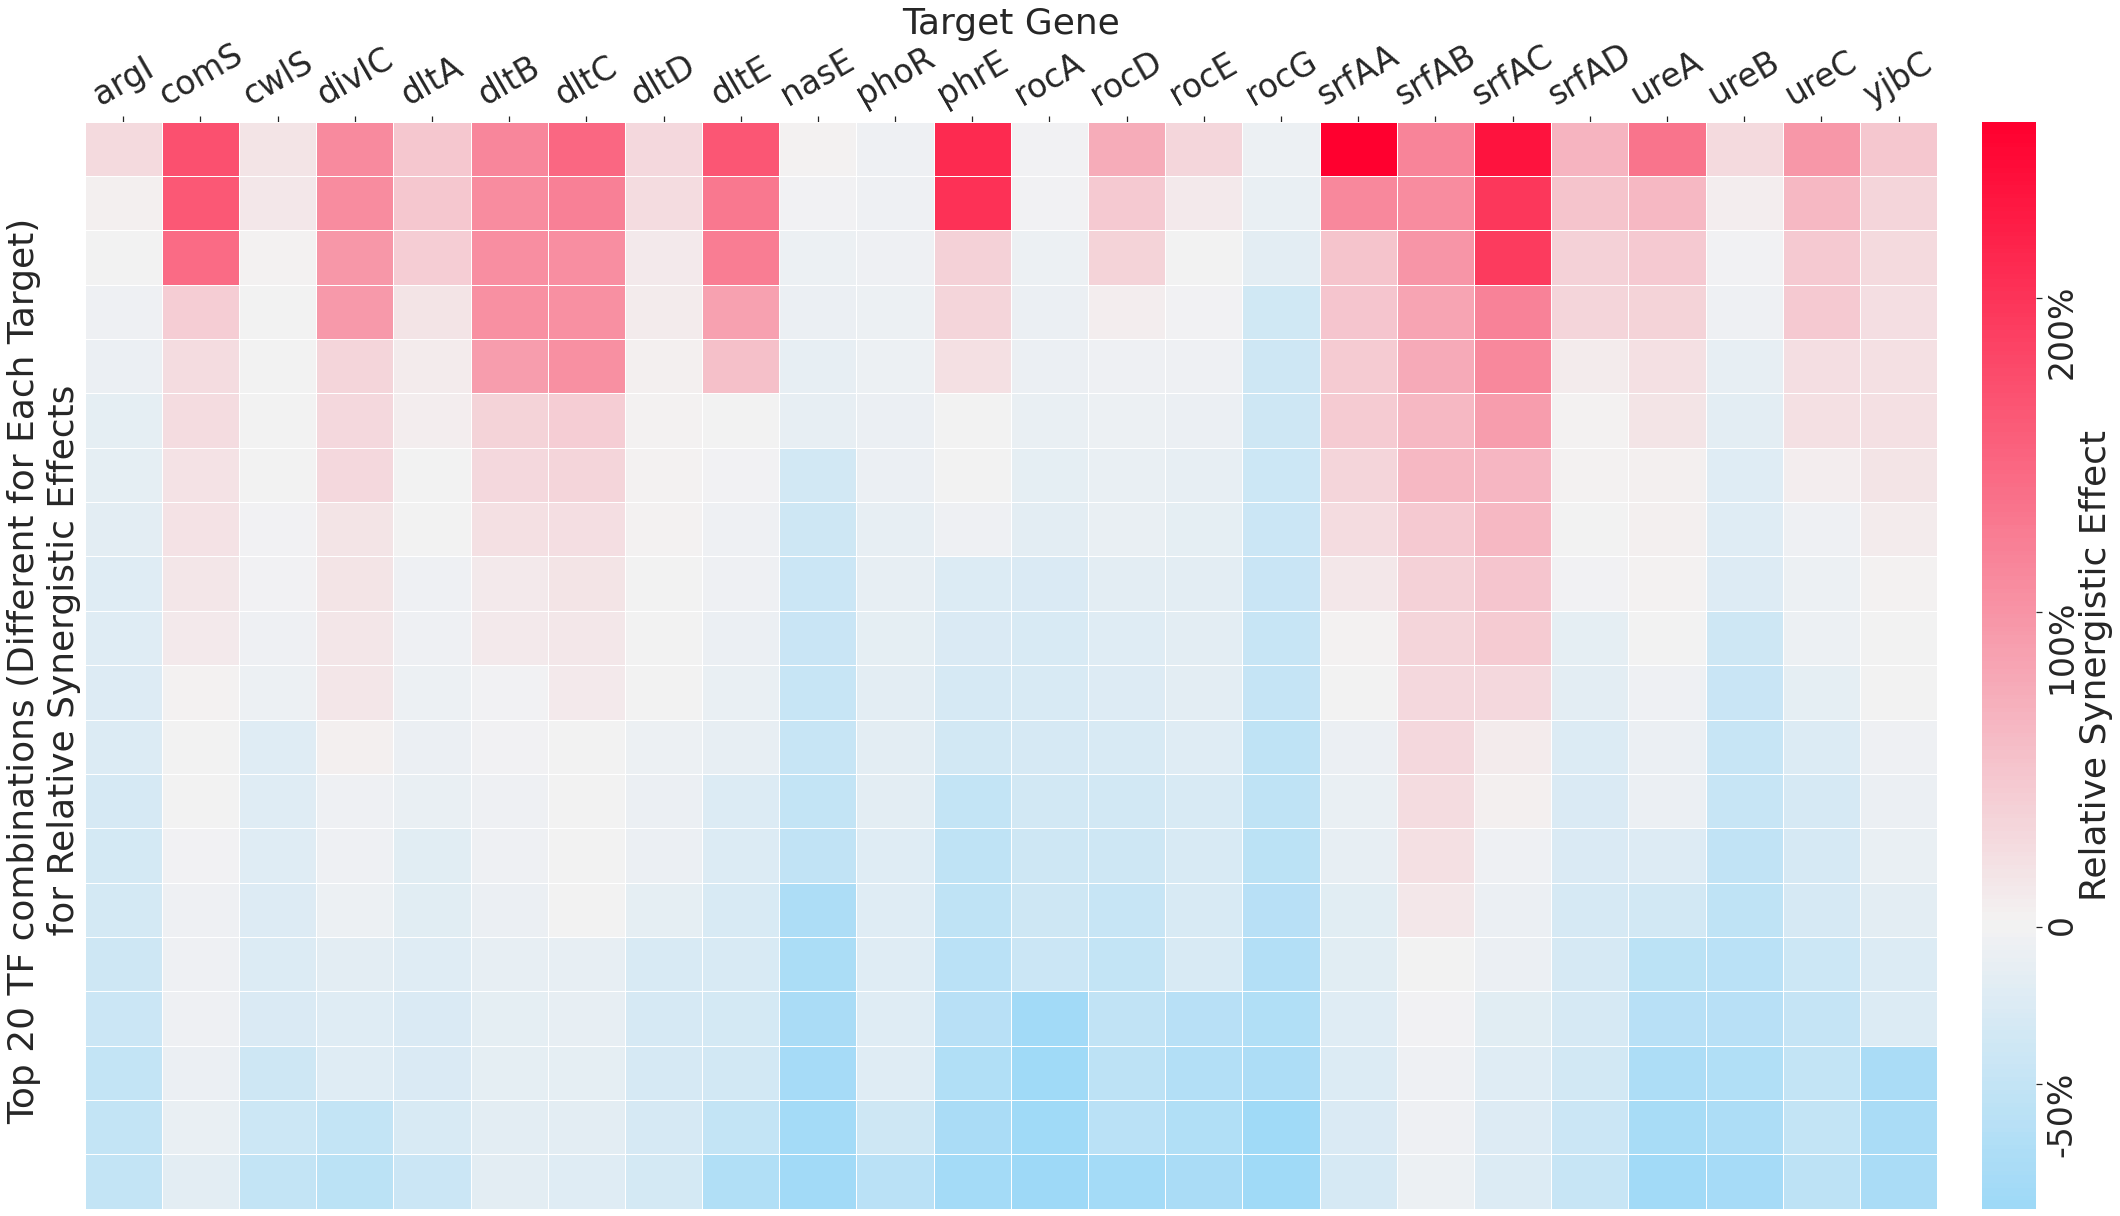

In [117]:
fig, ax = plt.subplots(figsize=(40,20))
sns.set(font_scale=3)
rdgn = sns.diverging_palette(h_neg=240, h_pos=0, s=300, l=55, sep=3, as_cmap=True)
sns.heatmap(subtilis_synergy_df, annot=False, ax=ax, center=0.00, cmap=rdgn, linewidths=1, cbar_kws={"pad": 0.02})
cbar = ax.collections[0].colorbar
cbar.set_ticks([-0.5, 0.0, 1, 2])
cbar.set_ticklabels(['-50%', '0', '100%', '200%'])
cbar.set_label('Relative Synergistic Effect', rotation=90,labelpad=0.2)
cbar.ax.tick_params(rotation=90)

ax.xaxis.tick_top()
ax.set_xlabel('Target Gene')    
ax.xaxis.set_label_position('top') 
ax.set_ylabel('Top 20 TF combinations (Different for Each Target) \n for Relative Synergistic Effects')
ax.set_yticks([])
plt.xticks(rotation=30)
plt.show()


In [150]:
measure_df_argsort = np.dstack(np.unravel_index(np.argsort(subtilis_synergy_df.values.ravel()), subtilis_synergy_df.shape))[0]
measure_df_argsort = np.flip(measure_df_argsort, axis=0)

In [155]:
top_combos = []
top_combo_effects = []
for row_i, column_i in measure_df_argsort[:20]:
    top_combo_effects.append(subtilis_synergy_df.iloc[row_i, column_i])
    top_combos.append(subtilis_synergy_name_df.iloc[row_i, column_i])

In [156]:
top_combo_df = pd.DataFrame(index=top_combos, data=top_combo_effects, columns=['Effects'])

In [158]:
top_combo_df.to_csv('./output/bsubtilis/top_combos.csv')